# Implementation of CORDIC Rotation in Julia

In [22]:
# Generate OQPSK Signal
using PyCall
using Random
push!(pyimport("sys")."path","../py")
phy = pyimport("mod_IEEE802154")
rng0 = MersenneTwister(0)
Fc = 2e6 # Bit Rate
Fs = 32e6 # Samping Rate
Fif = 1.2e6 # Intermediate Frequency
BW = 12 # Quantization
tx_bits = rand(rng0,[1,0],2000) # Bits  (Random for now)
(tx_bb_i, tx_bb_q) = phy.modOQPSK(tx_bits,Fs=Fs,Fc=Fc) # Signal at baseband

([-0.0, -0.0980171403295606, -0.19509032201612825, -0.29028467725446233, -0.3826834323650898, -0.47139673682599764, -0.5555702330196022, -0.6343932841636455, -0.7071067811865475, -0.7730104533627369  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.8314696123025455, 0.7730104533627371, 0.7071067811865476, 0.6343932841636455, 0.5555702330196022, 0.4713967368259978, 0.38268343236508984, 0.29028467725446233, 0.19509032201612858, 0.09801714032956084])

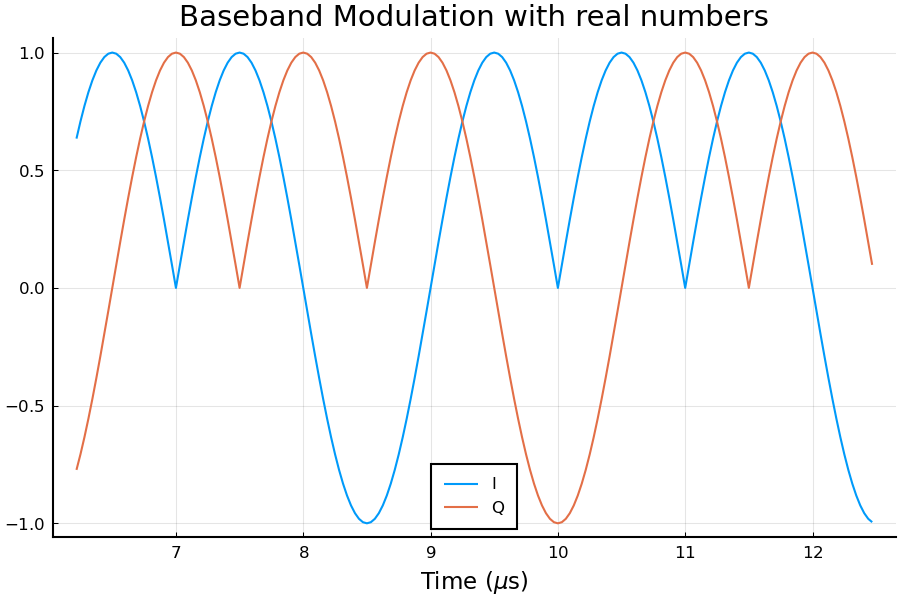

In [23]:
# Visualize OQPSK Signal
using Plots
pyplot()
Plots.PyPlotBackend()

k=200:400
p = plot( (k .-1) ./ Fs .* 1e6 ,tx_bb_i[k], label="I")
plot!(p,(k .- 1) ./ Fs .* 1e6 ,tx_bb_q[k], 
    label="Q",
    dpi=150,
    xlabel = "Time (\$\\mu\$s)",
    title = "Baseband Modulation with real numbers"
)

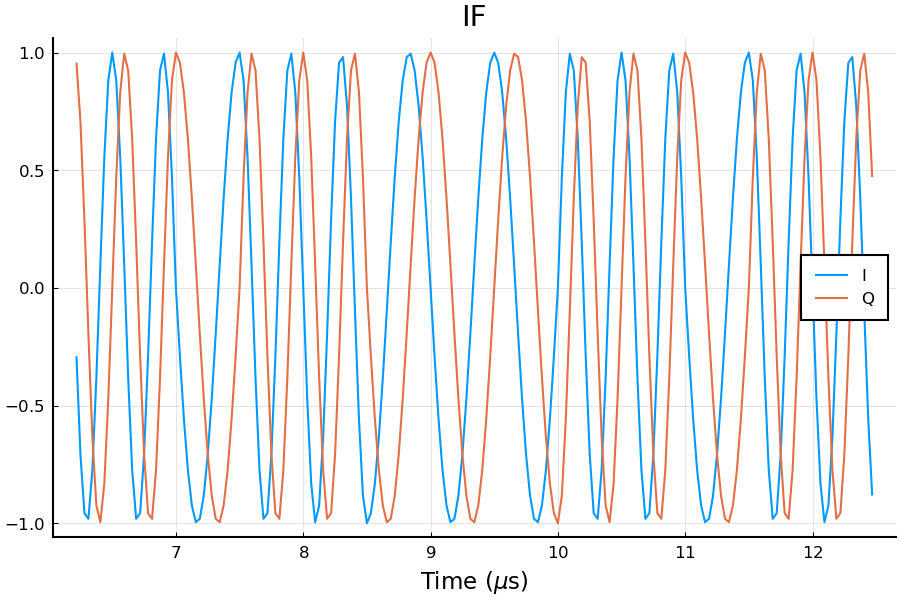

In [24]:
# Shift the O-QPSK signal up with mulitplication
Fif = 2e6
(tx_if_i,tx_if_q) = phy.shift_up(tx_bb_i,tx_bb_q,Fif,Fs=Fs)
k=200:400
p = plot( (k .-1) ./ Fs .* 1e6 ,tx_if_i[k], label="I")
plot!(p,(k .- 1) ./ Fs .* 1e6 ,tx_if_q[k], 
    label="Q",
    dpi=150,
    xlabel = "Time (\$\\mu\$s)",
    title = "IF"
)

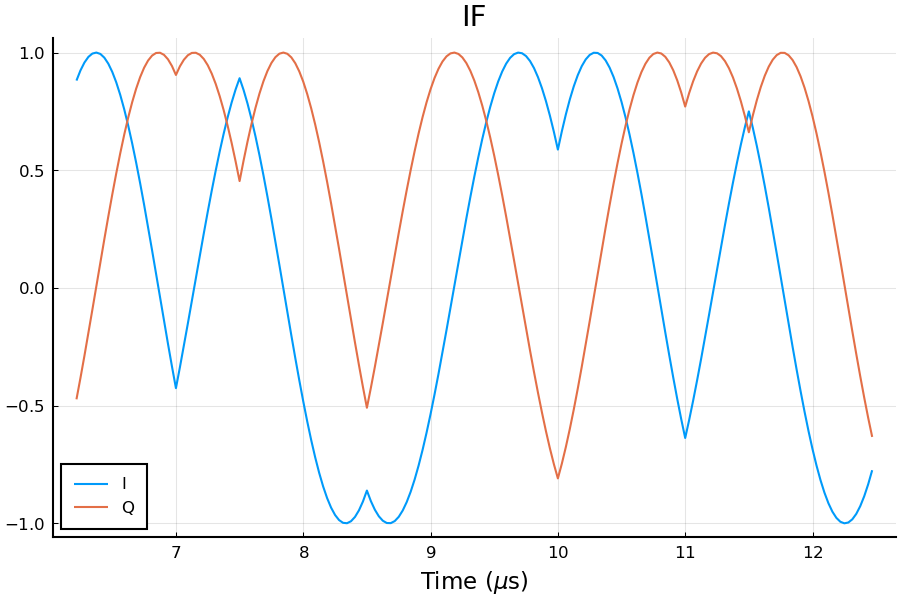

In [34]:
# Shift the signal down using multiplication
(rx_bb_i,rx_bb_q) = phy.shift_down(tx_if_i,tx_if_q,Fif-1e4,Fs=Fs)
k=200:400
p = plot( (k .-1) ./ Fs .* 1e6 ,rx_bb_i[k], label="I")
plot!(p,(k .- 1) ./ Fs .* 1e6 ,rx_bb_q[k], 
    label="Q",
    dpi=150,
    xlabel = "Time (\$\\mu\$s)",
    title = "IF"
)

In [6]:
# Define Cordic algorithm
function cordic_s(x,y,z,d,k)
    
    xn = x + d*y*2.0^(-k) 
    yn = y - d*x*2.0^(-k) 
    zn = z - d*atan(2.0^(-k))
    
    return xn,yn,zn
end
    
   
function crotate(x,y,a,n)
    dk = 1.0
    (xk,yk,zk) =  (x,y,a) 
    # First Gross Rotation by pi/2
    while(abs(zk) > pi/2)
       (xk, yk) = [0 1;-1 0] * [xk;yk]
        zk -= pi/2 * sign(zk)
    end
        
    for i=0:n
        (xk,yk,zk) = cordic_s(xk,yk,zk,dk,i)
        dk=sign(zk)
#         @show (xk,yk,zk,dk)
    end
    return xk,yk,zk
end

crotate (generic function with 1 method)

(atan(ye / xe) / pi) * 180 = -45.000133848275276


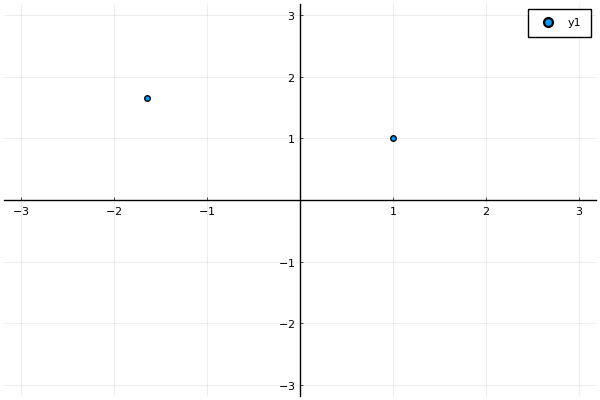

In [7]:
# Test Crotate
using Plots


(xs,ys,as) = (1,1,3*pi/2) 

(xe,ye,ae) = crotate(xs,ys,as,16)

@show atan(ye/xe)/pi*180

p = scatter(
    [xs,xe],[ys,ye],
    framestyle=:origin,
    xlim=[-3,3],
    ylim=[-3,3],
)

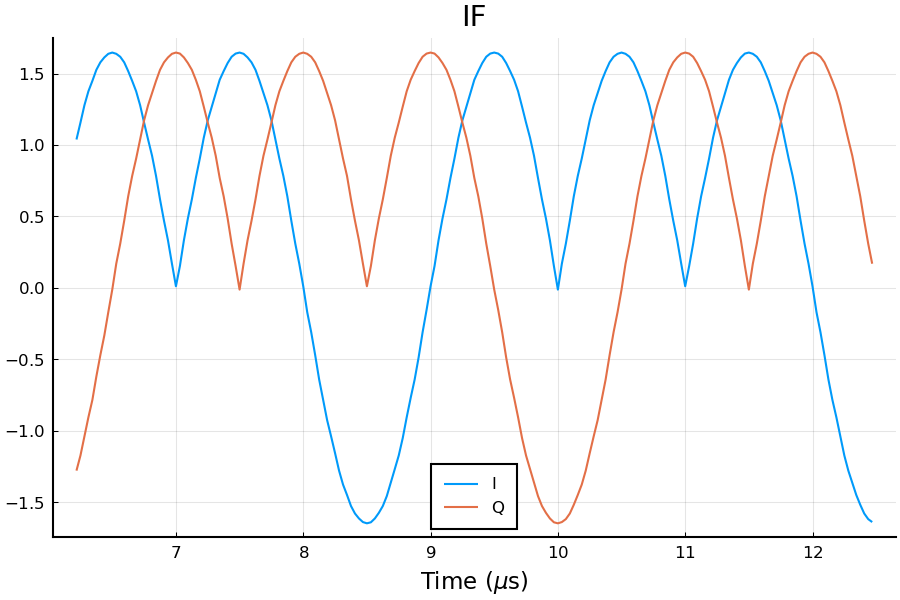

In [9]:
# Test Crotate on the shifted up OQPSK Signal

k = 1:length(tx_if_i)

theta = (2*pi*Fif/Fs) .* (k.-1)
theta = (theta - floor.(theta/2/pi) .* 2 .* pi)

rx_bbc_iq = map(
    (x,y,z) -> crotate(x,y,z,7),
    tx_if_i,
    tx_if_q,
    theta,
) 

(rx_bbc_i, rx_bbc_q) = ([s[i] for s=rx_bbc_iq] for i=1:2)


k=200:400
p = plot( (k .-1) ./ Fs .* 1e6 ,rx_bbc_i[k], label="I")
plot!(p,(k .- 1) ./ Fs .* 1e6 ,rx_bbc_q[k], 
    label="Q",
    dpi=150,
    xlabel = "Time (\$\\mu\$s)",
    title = "IF"
)


In [21]:
# Digitize and save the if input to be used as stimuli
BW=12
Att = 4
(rx_if_i, rx_if_q) = [
    convert.(Int,round.(s.*((2.0^(BW-1)-1)/Att)))
    for s = (tx_if_i,tx_if_q)
]

k=200:400
p = plot( (k .-1) ./ Fs .* 1e6 ,rx_if_i[k], label="I")
plot!(p,(k .- 1) ./ Fs .* 1e6 ,rx_if_q[k], 
    label="Q",
    dpi=150,
    xlabel = "Time (\$\\mu\$s)",
    title = "IF"
)

hcat(rx_if_i,rx_if_q) |> display

open("../sim/stimuli/iq_if_clean.txt","w") do f
    for (i,q) = eachrow(hcat(rx_if_i,rx_if_q))
        write(f,"$i\t$q\n")
    end
end

32016×2 Array{Int64,2}:
    0     0
  -46   -19
  -71   -71
  -57  -137
    0  -196
   92  -223
  201  -201
  300  -124
  362     0
  365   151
  301   301
  173   417
    0   473
    ⋮  
 -473     0
 -417  -173
 -301  -301
 -151  -365
    0  -362
  124  -300
  201  -201
  223   -92
  196     0
  137    57
   71    71
   19    46